# Packages and Loading Data

In [29]:
# Needs more work

In [13]:
import pandas as pd
import scipy.stats as sst
import matplotlib.pyplot as plt

from itertools import combinations
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [14]:
df = pd.read_csv("../data/processed/train_data.csv", index_col = 0)

# Class

In [16]:
class EDA():

    def __init__(self, df, conv_binary : bool = True):
        self.df = df

        self.qual_cols = None
        self.quant_cols = None

        if conv_binary:
            self.convert_binary()

        self.indentify_col_types()
    
    def basic_info(self):
        """
        The function retunrs a display of a basic information
        about the dataset
        """

        print("first 5 rows :")
        display(self.df.head())
        print(300 * '-')

        print("dataframe info : ")
        print(self.df.info())
        print(300 * '-')

        print("description of quantitative columns : ")
        display(self.df.describe())
        print(300 * '-')

        print("description of qualitative columns : ")
        display(self.df.describe(include = 'O'))
        print(300 * '-')
    
    def n_unique_values(self):
        """
        The function displays a dataframe with the count of
        unique values for each column in the dataset
        """

        display(self.df.nunique().reset_index().rename({"index" : "col_name", 0 : "n_unique_values"}, axis = 1))
    
    def convert_binary(self):
        """
        The function converts binary columns from a quantitative format to a 
        qualitative one for clearer analysis
        """

        df = self.df

        df_quant_unique = df.select_dtypes(include = "number").nunique().reset_index().rename({"index" : "col_name", 0 : "n_unique_values"}, axis = 1)

        if len(df_quant_unique) > 0:
            if len(df_quant_unique[df_quant_unique.n_unique_values == 2]) > 0:

                binary_cols = df_quant_unique.loc[df_quant_unique.n_unique_values == 2, "col_name"].tolist()

                for col in binary_cols:
                    self.df[col] = self.df[col].map({0 : "false", 1 : "true"})
    
    def indentify_col_types(self):
        """
        This function creates a list of quantitative columns and one 
        of qualititative columns contianed in the dataset
        """
        
        self.qual_cols = self.df.select_dtypes(include = "object").columns.tolist()
        self.quant_cols = self.df.select_dtypes(exclude = "object").columns.tolist()

    def missing_values_check(self):
        """
        This function returns how many missing values per column 
        are present in the dataset
        """

        print(self.df.isna().sum())
    
    def duplicates_check(self):
        """
        This functions returns the sum of duplicate rows present
        in the dataset
        """

        print(self.df.duplicated().sum())
    
    def summary_table(self, col : str, max_col_display : int = 10) -> pd.DataFrame:
        """
        create summary table for a qualitative column, consisting of a column wiht the count for each value and the 
        corresponding percentage in an other column. The parameter max_col_display determines how many rows will be 
        displayed, the others will be aggregated in a single value named other.
        """

        df = self.df
        
        df_counts = df[col].value_counts().reset_index().rename({"count" : "counts"}, axis = 1)
        df_percs = df[col].value_counts(normalize = True).reset_index().rename({"proportion" : "percentages" }, axis = 1)
        df_percs.percentages = df_percs.percentages.apply(lambda x : round(x * 100, 2))

        df_summary_table = pd.merge(left = df_counts, right = df_percs, on = col, how = "inner")

        if len(df[col].unique().tolist()) > max_col_display:
            other_counts = df_summary_table.loc[max_col_display:, "counts"].sum()
            other_percentage = round((other_counts / len(df)) * 100, 2)

            df_summary_table = df_summary_table.loc[:max_col_display - 1].copy()

            df_summary_table.loc[len(df_summary_table)] = {col : "other", "counts" : other_counts, "percentages" : other_percentage}

        return df_summary_table
    
    def plot_univ_qual(self, df_summary_table : pd.DataFrame, col : str) -> plt.figure:
        """
        using the summary table of a qualitative column the functions plots a bar chart
        and a pie chart.
        """

        x = df_summary_table[col]
        y1 = df_summary_table.counts
        y2 = df_summary_table.percentages

        fig, ax = plt.subplots(1, 2, figsize = (15, 5))

        # bar chart
        ax[0].bar(x, y1)

        ax[0].set_xticks(range(len(x)))
        ax[0].set_xticklabels(x.values.tolist(), rotation = 45, ha = 'right')

        # pie chart
        ax[1].pie(y1, labels = x, autopct='%1.1f%%')

        ax[1].set(xlabel = col)

        plt.show()
    
    def univ_qual_all(self):
        """
        This function computes the summary table and then plots the 
        graphs for the univariate analysis for all the qualitative columns
        """

        for col in self.qual_cols:
            df_summary_table = self.summary_table(col = col)

            print(f"column name : {col}")
            
            print("\n")

            print("summary_table")
            display(df_summary_table)

            print("\n")

            print("graphs")
            self.plot_univ_qual(df_summary_table = df_summary_table, col = col)

            print("-" * 300)
    
    def frequency_table(self, col : str, bins : int = 5) -> pd.DataFrame:
        """
        Compute a frequency table for a quantitative column in the dataframe given. The table conisits
        of the bins that group the values(border values and center value), the count of how many values are in each bin, the perecentage of values
        in each bin, and the cumulative percentage. The variable bin decides how many bins are created.
        """

        df = self.df

        df_obj = df[[col]].copy()
        df_obj["bins"] = pd.cut(df[col], bins = bins)

        df_freq_table = df_obj.groupby(by = "bins", observed = False).count().reset_index().rename({col : "counts"}, axis = 1)
        df_freq_table["mid_bin"] = df_freq_table.bins.apply(lambda x : round((x.left + x.right) / 2, 1))
        df_freq_table["percentages"] = df_freq_table.counts.apply(lambda x : (x / len(df)) * 100)
        df_freq_table["cum_percentages"] = df_freq_table.percentages.cumsum()

        df_freq_table = df_freq_table[["mid_bin", "bins", "counts", "percentages", "cum_percentages"]]

        return df_freq_table
    
    def plot_univ_quant(self, col : str, df_frequency_table : pd.DataFrame) -> plt.figure:
        """
        The functions plots an histogram chart and a box chart for the quantitative column.
        """

        df = self.df

        all_bins = list(df_frequency_table.bins)
        left_border_bins = [x.left for x in all_bins]
        left_border_bins.append(all_bins[-1].right)

        x = df_frequency_table.mid_bin
        y = list(df_frequency_table.counts)
        y.append(0)


        fig, ax = plt.subplots(1, 2, figsize = (15, 5))

        # histogram
        ax[0].hist(left_border_bins, bins = len(df_frequency_table) , align = 'mid', weights= y)

        ax[0].set(xticks = x, ylabel = 'count')

        # boxplot 
        ax[1].boxplot(df[col], vert = False)

        plt.show()
    
    def univ_quant_all(self):
        """
        This function computes the frequncy table and then plots the 
        graphs for the univariate analysis for all the quantitative columns
        """

        for col in self.quant_cols:
            df_frequency_table = self.frequency_table(col = col)

            print(f"column name : {col}")
            
            print("\n")

            print("frequency_table")
            display(df_frequency_table)

            print("\n")

            print("graphs")
            self.plot_univ_quant(col = col, df_frequency_table = df_frequency_table)

            print("-" * 300)
    
    def contingency_table(self, col1 : str, col2 : str) -> tuple[pd.DataFrame, float]:
        """
        The function computes the contingency table for a pair of qualitative columns of the dataset,
        it returns also the cramer v.
        """

        df = self.df

        df_cont_table = pd.crosstab(df[col1], df[col2], margins = True)

        x2, p, dof, expected = sst.chi2_contingency(df_cont_table, correction=False)
        min_dim = min(df_cont_table.shape) - 1
        n = df_cont_table.loc['All', 'All']

        cramerv = np.sqrt((x2/n)/ min_dim)

        return df_cont_table, cramerv
    
    def plot_biv_qual(self, df_cont_table : pd.DataFrame) -> plt.figure:
        """
        The functions plots a side by side bar chart and a stacked one 
        for a pair of qualitative columns of the dataset.
        """

        df_cont_table_obj = df_cont_table.drop('All', axis = 1)
        df_cont_table_obj = df_cont_table_obj.drop('All', axis = 0)


        fig, ax = plt.subplots(1, 2, figsize = (15, 5))

        # side by side
        df_cont_table_obj.plot(kind='bar', ax = ax[0])

        # stacked 
        df_cont_table_obj.plot(kind = 'bar', stacked=True, ax = ax[1])

        plt.show()
    
    def biv_qual_all(self, col_exclude : list = None):
        """
        This function computes the contigency table and cramer v and then plots
        the graphs for the bivariate analysis for all qualitative columns pairs in
        the dataset
        """

        qual_cols_obj = self.qual_cols[:]

        if col_exclude:
            
            for col in col_exclude:
                qual_cols_obj.remove(col)
        

        for pair in combinations(qual_cols_obj, 2):
            col1 = pair[0]
            col2 = pair[1]

            df_cont_table, cramerv = self.contingency_table(col1 = col1, col2 = col2)

            print(f"column 1 name : {col1}, column 2 name : {col2}")

            print("\n")

            print("contingency_table")
            display(df_cont_table)

            print("\n")

            print(f"cramer v : {cramerv}")

            print("\n")

            print("graphs")
            self.plot_biv_qual(df_cont_table = df_cont_table)

            print("-" * 300)
    
    def correlation_table(self, col1 : str, col2 : str) -> pd.DataFrame:
        """
        The function computes a correlation table between two quantitative columns,
        which reports the covariance, and the correlation between the two, as well as 
        the p value of the correlation.
        """
        df = self.df

        covariance = df[col1].cov(df[col2])
        r_val, p_val = sst.pearsonr(df[col1], df[col2])

        return pd.DataFrame({"covariance" : covariance, "r" : r_val, "p_val" : p_val}, index=[0])
    
    def plot_biv_quant(self, col1 : str, col2 : str) -> plt.figure:
        """
        The function plots a scatter graph for two quantitative columns of the dataset.
        """
        df = self.df

        fig, ax = plt.subplots(1, 1, figsize = (7,2))

        ax.scatter(df[col1], df[col2])

        ax.set(xlabel = col1, ylabel = col2)

        plt.show()
    
    def biv_quant_all(self, col_exclude : list = None):
        """
        This function computes the correlation_table and then plots
        the graph for the bivariate analysis for all quantitative columns pairs in
        the dataset
        """

        quant_cols_obj = self.quant_cols[:]

        if col_exclude:
            
            for col in col_exclude:
                quant_cols_obj.remove(col)

        for pair in combinations(quant_cols_obj, 2):
            col1 = pair[0]
            col2 = pair[1]

            df_corr_table = self.correlation_table(col1 = col1, col2 = col2)

            print(f"column 1 name : {col1}, column 2 name : {col2}")

            print("\n")

            print("correlation_table")
            display(df_corr_table)

            print("\n")

            print("graphs")
            self.plot_biv_quant(col1 = col1, col2 = col2)

            print("-" * 300)

        print("\n")

        print("correlation matrix")
        display(df[quant_cols_obj].corr())
    
    def anova_table(self, col_quant : str, col_qual : str) -> pd.DataFrame:
        """
        This function computes the anova table for a quantitative column and a qualitative one.
        """

        df = self.df

        model = ols(f"{col_quant} ~ {col_qual}", data = df).fit()
        df_anova_table = anova_lm(model)

        return df_anova_table
    
    def plot_biv_both(self, col_quant : str, col_qual : str) -> plt.figure:
        """
        This function creates a box plot of the quantitative column splitting in different box 
        depending on which is their corresponding value for the qualitative column.
        """
        
        df = self.df

        unique_qual_list = list(df[col_qual].unique())

        plot_data = []

        for qual_val in unique_qual_list:
            plot_data.append(df[col_quant][df[col_qual] == qual_val])
        
        fig, ax = plt.subplots(1, 1, figsize = (7,4))

        box = ax.boxplot(plot_data, labels = unique_qual_list)

        ax.set_xticklabels(unique_qual_list, rotation = 45, ha = 'right')

        plt.show()
    
    def biv_quant_qual_all(self, col_quant_exclude : list = None, col_qual_exclude : list = None):
        """
        This function computes the anova table and then plots the graphs 
        for the bivariate analysis for all columns pairs compesed of one 
        quantitative and one qualitative in the dataset
        """

        quant_cols_obj = self.quant_cols[:]

        if col_quant_exclude:
            
            for col in col_quant_exclude:
                quant_cols_obj.remove(col)

        qual_cols_obj = self.qual_cols[:]

        if col_qual_exclude:
            
            for col in col_qual_exclude:
                qual_cols_obj.remove(col)

        for col_quant in quant_cols_obj:
            for col_qual in qual_cols_obj:

                df_anova_table = self.anova_table(col_quant = col_quant, col_qual = col_qual)

                print(f"column quantitative name : {col_quant}, column qualitative name : {col_qual}")

                print("\n")

                print("anova_table")
                display(df_anova_table)

                print("\n")

                print("graphs")
                self.plot_biv_both(col_qual = col_qual, col_quant = col_quant)

                print("-" * 300)

In [17]:
eda = EDA(df = df)

# Basic Information

In [18]:
eda.basic_info()

first 5 rows :


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
5518783,380,CASH_OUT,28302.64,C1523548072,30672.0,2369.36,C13451159,0.00,28302.64,false,false
6270214,619,CASH_OUT,76064.78,C1125482892,86.0,0.00,C1823993014,160930.30,236995.08,false,false
4829282,347,CASH_OUT,14077.86,C622858743,5224.0,0.00,C4599462,1838229.25,1852307.11,false,false
4756151,333,PAYMENT,19735.56,C1406405905,560113.0,540377.44,M1606969845,0.00,0.00,false,false
3314305,252,CASH_OUT,223784.46,C810059506,31734.0,0.00,C1937196092,3380175.65,3603960.11,false,false


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
dataframe info : 
<class 'pandas.core.frame.DataFrame'>
Index: 4453834 entries, 5518783 to 5020228
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         object 
 10  isFlaggedFraud  object 
dtypes: float64(5), int64(1), object(5)
memory usage: 407.8+ MB
None
-------------------------------------------------------------------------------------------------------------------------

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
count,4.453834e+06,4.453834e+06,4.453834e+06,4.453834e+06,4.453834e+06,4.453834e+06
mean,2.434329e+02,1.798308e+05,8.349690e+05,8.561846e+05,1.099587e+06,1.223763e+06
std,1.423499e+02,6.057019e+05,2.890072e+06,2.925869e+06,3.396338e+06,3.671237e+06
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338192e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.483697e+04,1.423900e+04,0.000000e+00,1.325666e+05,2.143375e+05
75%,3.350000e+02,2.086177e+05,1.074570e+05,1.443340e+05,9.413244e+05,1.109779e+06
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
description of qualitative columns : 


,type,nameOrig,nameDest,isFraud,isFlaggedFraud
count,4453834,4453834,4453834,4453834,4453834
unique,5,4449332,2035337,2,2
top,CASH_OUT,C1065307291,C985934102,false,false
freq,1565898,3,79,4448085,4453823


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


# Data Quality

## Missing Values

In [19]:
eda.missing_values_check()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


## Duplicates

In [20]:
eda.duplicates_check()

0


# Univariate Analysis

## Qualitative Columns

column name : type


summary_table


,type,counts,percentages
0,CASH_OUT,1565898,35.16
1,PAYMENT,1506583,33.83
2,CASH_IN,979400,21.99
3,TRANSFER,372793,8.37
4,DEBIT,29160,0.65




graphs


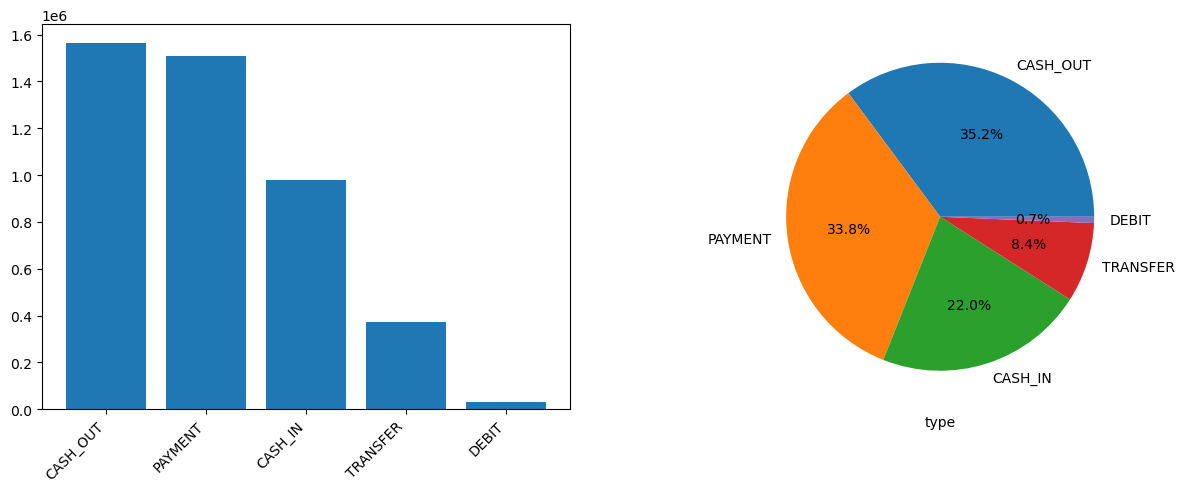

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
column name : nameOrig


summary_table


,nameOrig,counts,percentages
0,C1065307291,3,0.0
1,C2051359467,3,0.0
2,C1976208114,3,0.0
3,C1784010646,3,0.0
4,C1782826285,2,0.0
5,C846956456,2,0.0
6,C105416572,2,0.0
7,C1121667184,2,0.0
8,C591446839,2,0.0
9,C1459240963,2,0.0




graphs


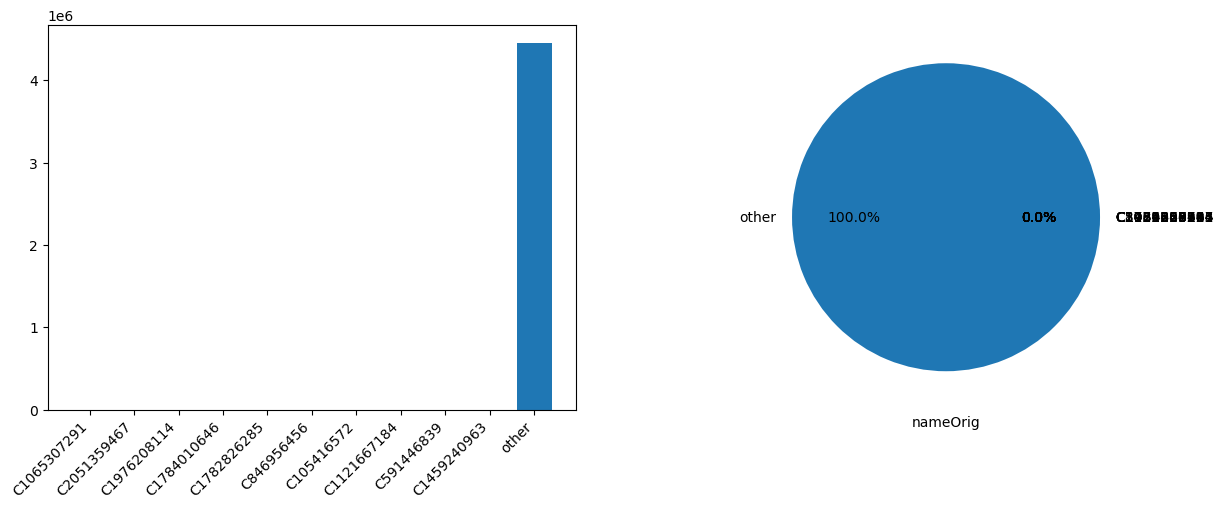

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
column name : nameDest


summary_table


,nameDest,counts,percentages
0,C985934102,79,0.00
1,C1286084959,77,0.00
2,C248609774,77,0.00
3,C665576141,75,0.00
4,C1590550415,75,0.00
5,C977993101,73,0.00
6,C451111351,73,0.00
7,C1789550256,71,0.00
8,C2083562754,70,0.00
9,C1023714065,69,0.00




graphs


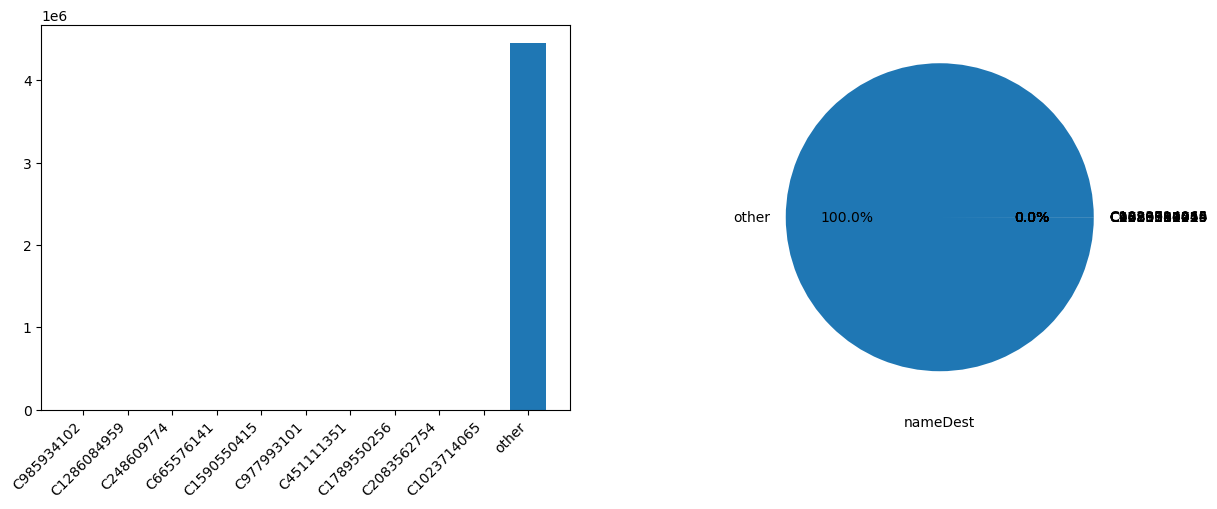

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
column name : isFraud


summary_table


,isFraud,counts,percentages
0,false,4448085,99.87
1,true,5749,0.13




graphs


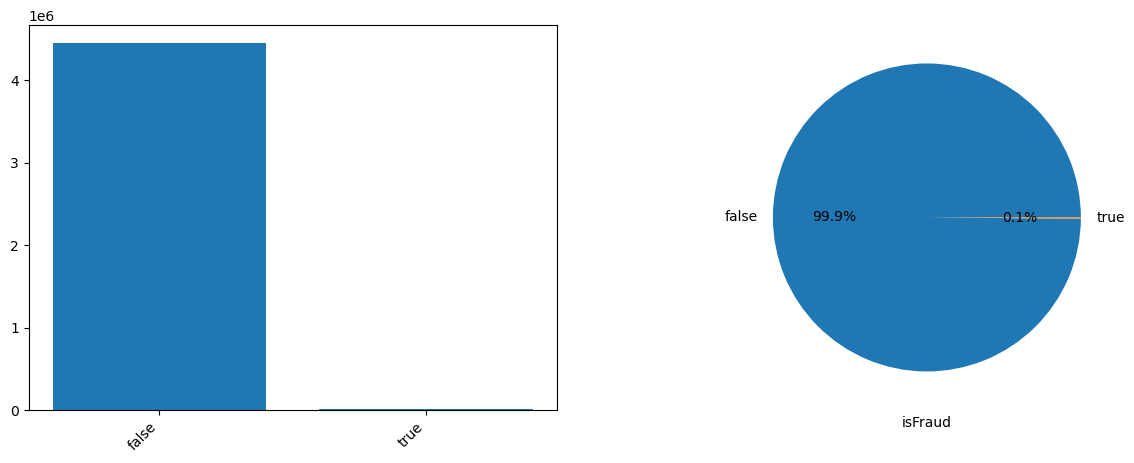

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
column name : isFlaggedFraud


summary_table


,isFlaggedFraud,counts,percentages
0,false,4453823,100.0
1,true,11,0.0




graphs


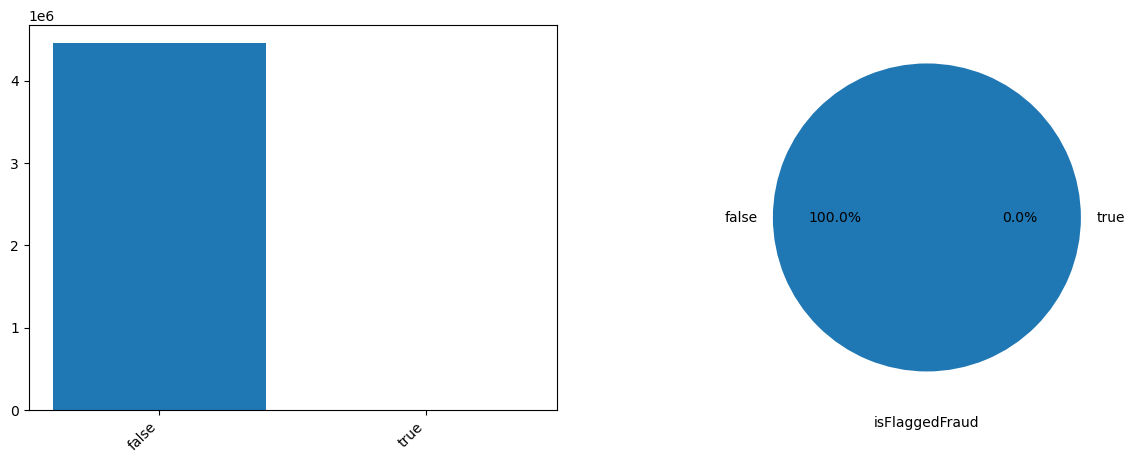

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [21]:
eda.univ_qual_all()

## Quantitative Columns

column name : step


frequency_table


,mid_bin,bins,counts,percentages,cum_percentages
0,74.8,"(0.258, 149.4]",1057765,23.749538,23.749538
1,223.6,"(149.4, 297.8]",1728601,38.811527,62.561065
2,372.0,"(297.8, 446.2]",1420961,31.904220,94.465285
3,520.4,"(446.2, 594.6]",159745,3.586685,98.051971
4,668.8,"(594.6, 743.0]",86762,1.948029,100.000000




graphs


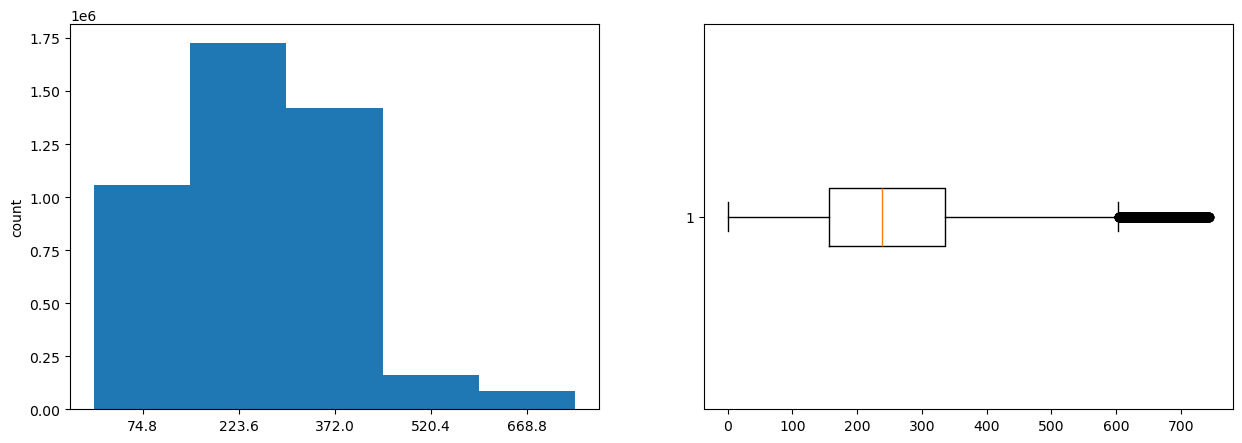

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
column name : amount


frequency_table


,mid_bin,bins,counts,percentages,cum_percentages
0,9198328.9,"(-92445.517, 18489103.328]",4453177,99.985249,99.985249
1,27733655.0,"(18489103.328, 36978206.656]",536,0.012035,99.997283
2,46222758.3,"(36978206.656, 55467309.984]",102,0.002290,99.999573
3,64711861.6,"(55467309.984, 73956413.312]",18,0.000404,99.999978
4,83200965.0,"(73956413.312, 92445516.64]",1,0.000022,100.000000




graphs


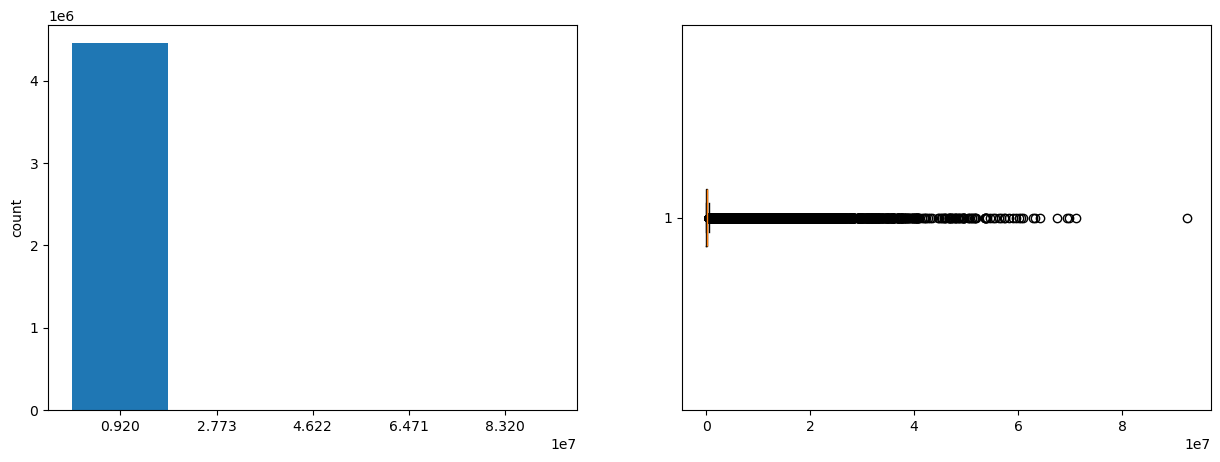

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
column name : oldbalanceOrg


frequency_table


,mid_bin,bins,counts,percentages,cum_percentages
0,5928711.5,"(-59585.04, 11917008.074]",4381176,98.368641,98.368641
1,17875512.1,"(11917008.074, 23834016.148]",61173,1.373491,99.742132
2,29792520.2,"(23834016.148, 35751024.222]",11463,0.257374,99.999506
3,41709528.3,"(35751024.222, 47668032.296]",18,0.000404,99.999910
4,53626536.3,"(47668032.296, 59585040.37]",4,0.000090,100.000000




graphs


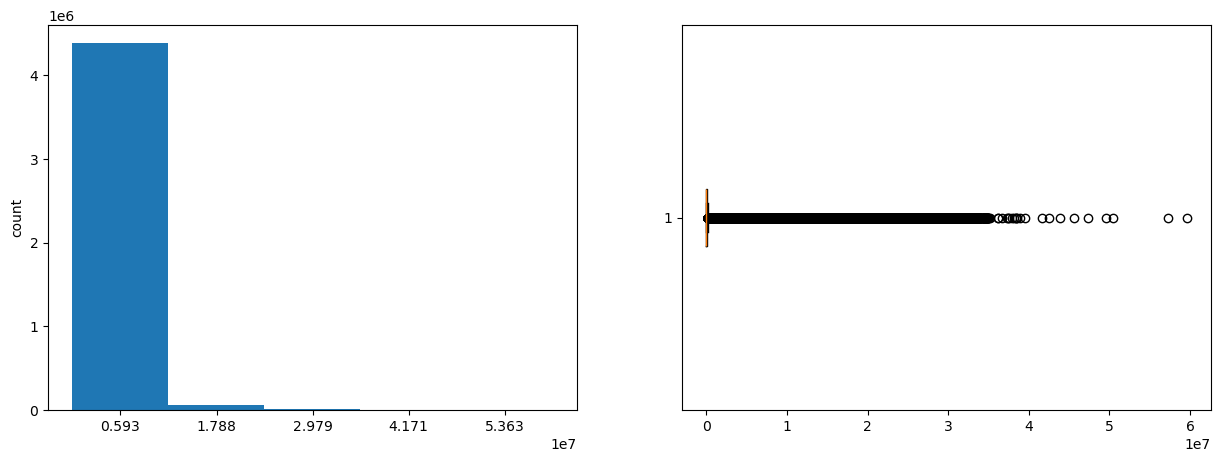

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
column name : newbalanceOrig


frequency_table


,mid_bin,bins,counts,percentages,cum_percentages
0,4933711.5,"(-49585.04, 9917008.074]",4350245,97.674161,97.674161
1,14875512.1,"(9917008.074, 19834016.148]",77309,1.735785,99.409947
2,24792520.2,"(19834016.148, 29751024.222]",25131,0.564255,99.974202
3,34709528.3,"(29751024.222, 39668032.296]",1144,0.025686,99.999888
4,44626536.3,"(39668032.296, 49585040.37]",5,0.000112,100.000000




graphs


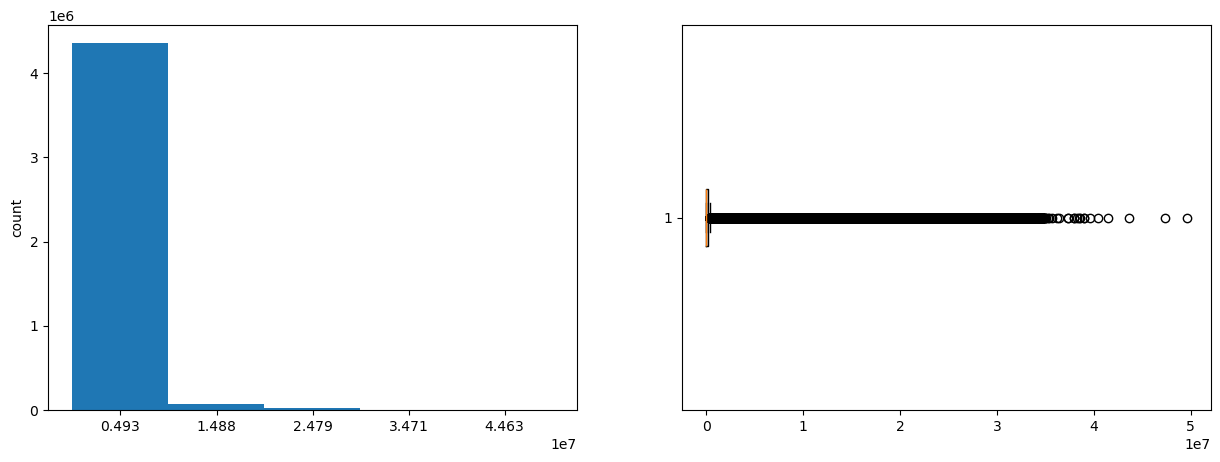

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
column name : oldbalanceDest


frequency_table


,mid_bin,bins,counts,percentages,cum_percentages
0,35423581.0,"(-356015.889, 71203177.87]",4452706,99.974674,99.974674
1,106804766.8,"(71203177.87, 142406355.74]",908,0.020387,99.995060
2,178007944.7,"(142406355.74, 213609533.61]",163,0.003660,99.998720
3,249211122.5,"(213609533.61, 284812711.48]",42,0.000943,99.999663
4,320414300.4,"(284812711.48, 356015889.35]",15,0.000337,100.000000




graphs


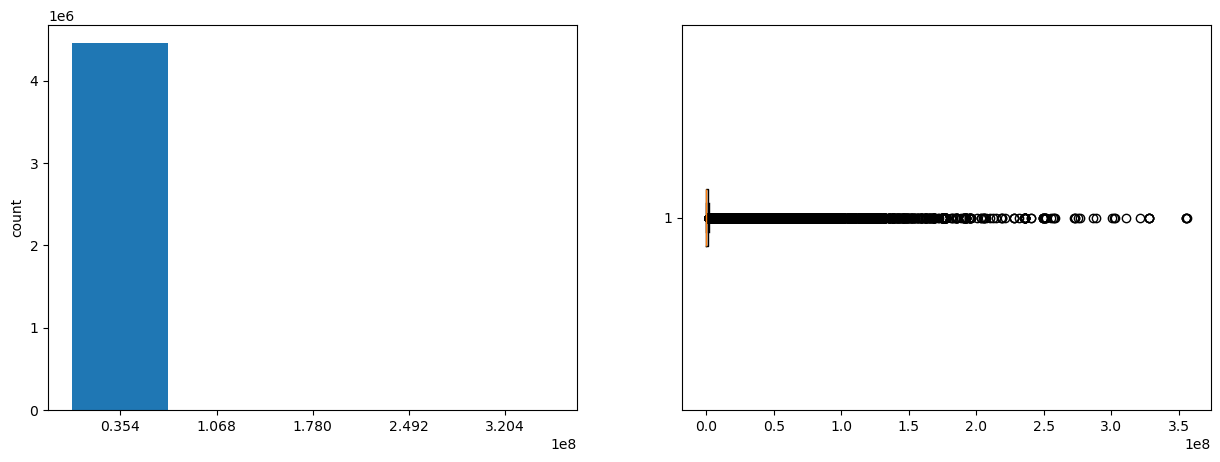

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
column name : newbalanceDest


frequency_table


,mid_bin,bins,counts,percentages,cum_percentages
0,35439838.3,"(-356179.279, 71235855.784]",4452446,99.968836,99.968836
1,106853783.7,"(71235855.784, 142471711.568]",1117,0.025080,99.993915
2,178089639.5,"(142471711.568, 213707567.352]",205,0.004603,99.998518
3,249325495.2,"(213707567.352, 284943423.136]",46,0.001033,99.999551
4,320561351.0,"(284943423.136, 356179278.92]",20,0.000449,100.000000




graphs


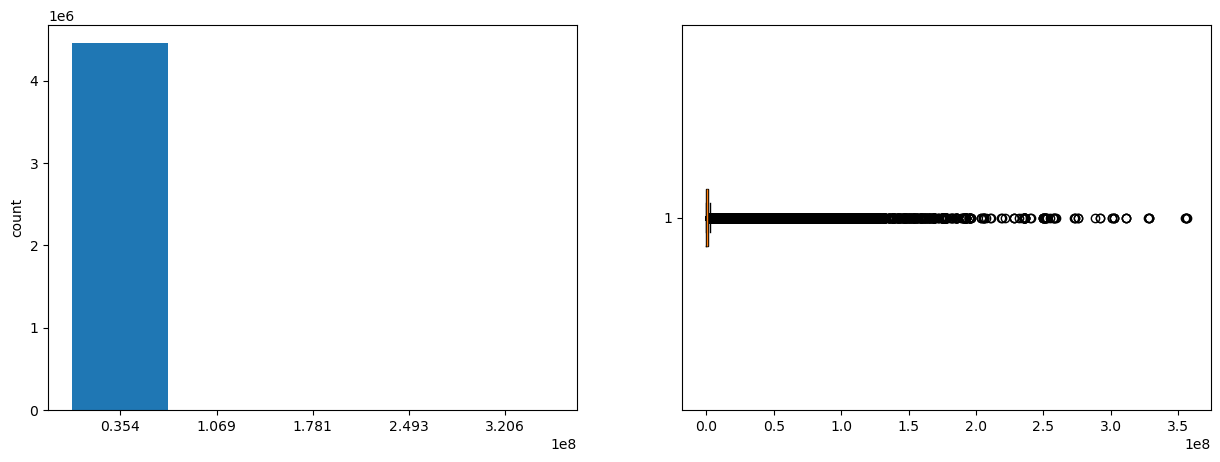

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [22]:
eda.univ_quant_all()

# Bivariate Analysis

## Qualitative Columns

The columns : nameOrig, and nameDest will be excluded as they have to many unique values requiring to much computing power while generating insight that is not valuable

column 1 name : type, column 2 name : isFraud


contingency_table


isFraud,false,true,All
type,,,
CASH_IN,979400,0,979400
CASH_OUT,1562995,2903,1565898
DEBIT,29160,0,29160
PAYMENT,1506583,0,1506583
TRANSFER,369947,2846,372793
All,4448085,5749,4453834




cramer v : 0.04140681459579007


graphs


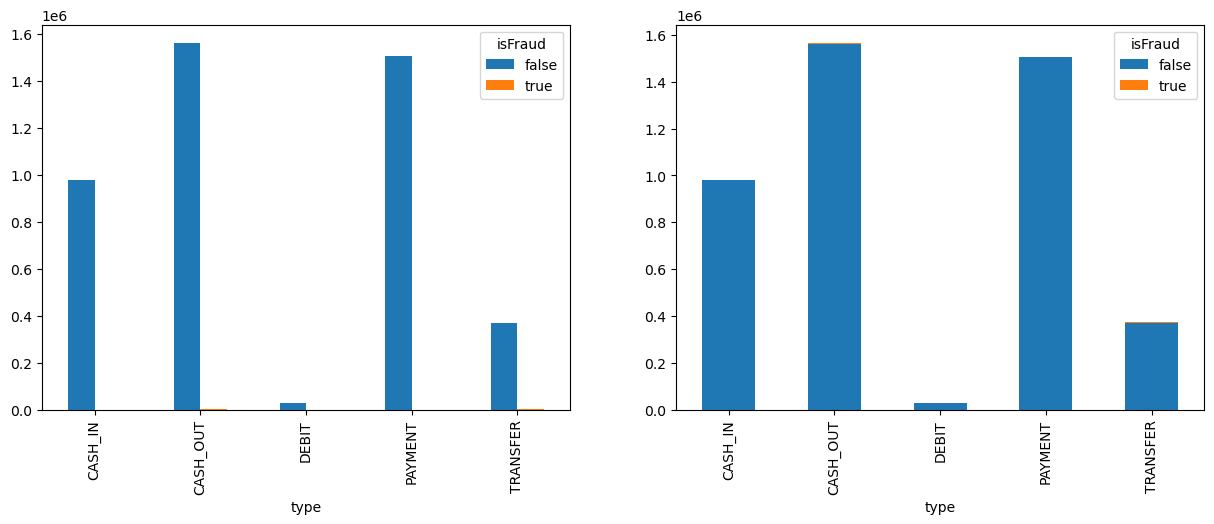

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
column 1 name : type, column 2 name : isFlaggedFraud


contingency_table


isFlaggedFraud,false,true,All
type,,,
CASH_IN,979400,0,979400
CASH_OUT,1565898,0,1565898
DEBIT,29160,0,29160
PAYMENT,1506583,0,1506583
TRANSFER,372782,11,372793
All,4453823,11,4453834




cramer v : 0.003676770075583559


graphs


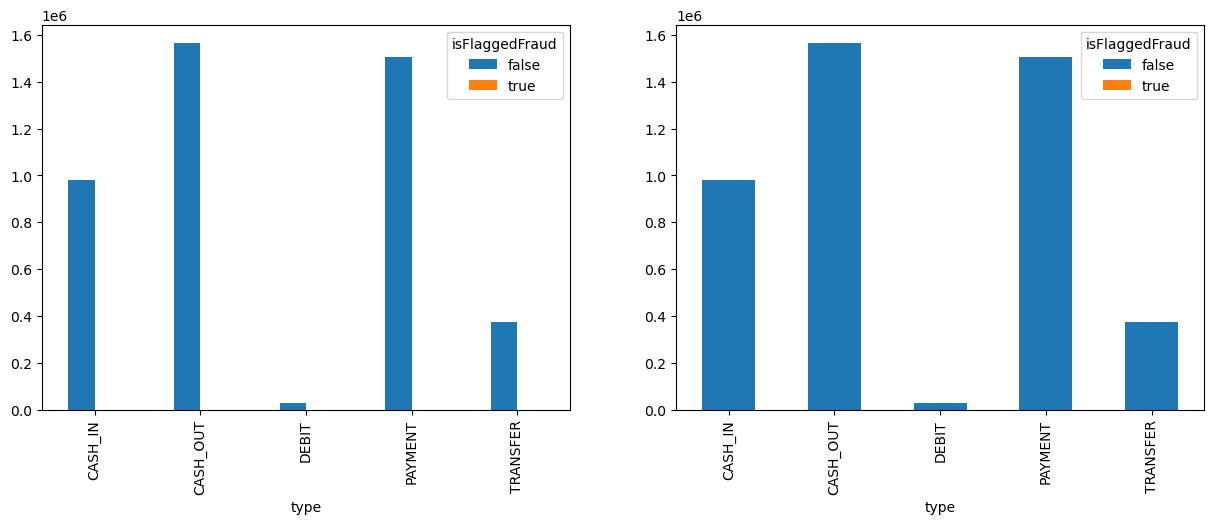

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
column 1 name : isFraud, column 2 name : isFlaggedFraud


contingency_table


isFlaggedFraud,false,true,All
isFraud,,,
false,4448085,0,4448085
true,5738,11,5749
All,4453823,11,4453834




cramer v : 0.03091044464793257


graphs


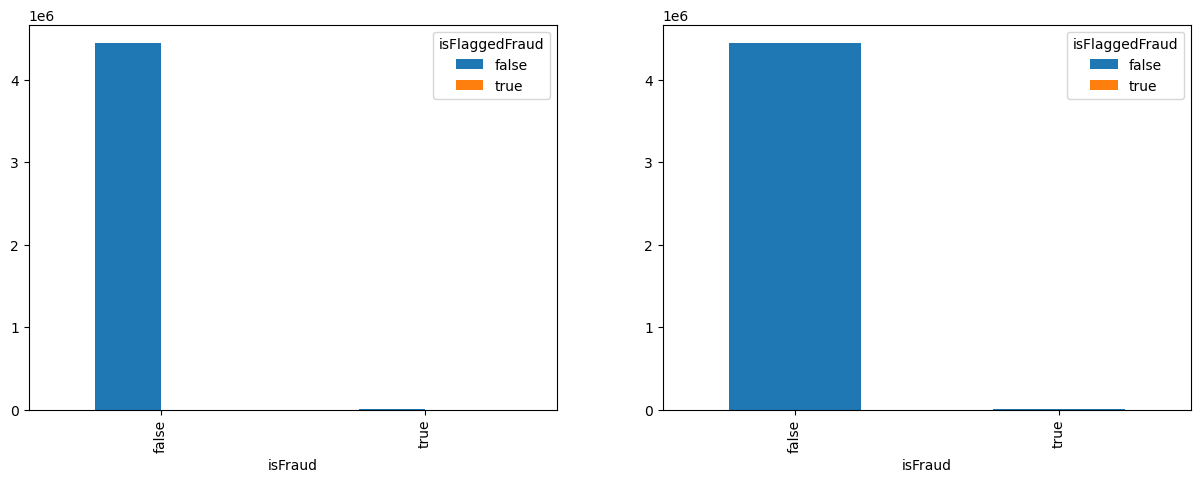

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [23]:
eda.biv_qual_all(col_exclude = ["nameDest", "nameOrig"])

## Quantitative Columns

column 1 name : step, column 2 name : amount


correlation_table


,covariance,r,p_val
0,1.944675e+06,0.022554,0.0




graphs


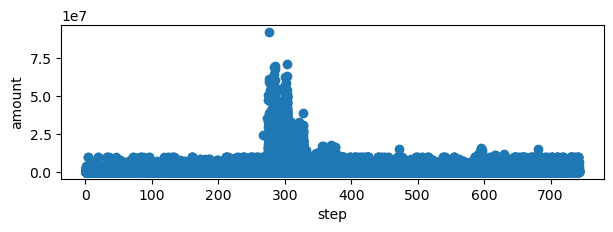

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
column 1 name : step, column 2 name : oldbalanceOrg


correlation_table


,covariance,r,p_val
0,-4.080609e+06,-0.009919,2.666320e-97




graphs


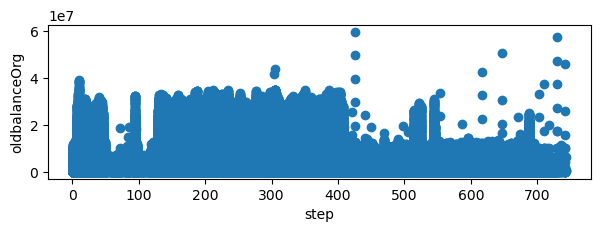

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
column 1 name : step, column 2 name : newbalanceOrig


correlation_table


,covariance,r,p_val
0,-4.233274e+06,-0.010164,4.493025e-102




graphs


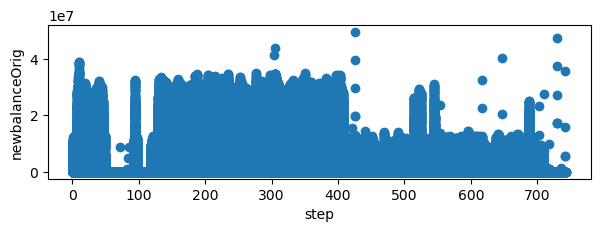

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
column 1 name : step, column 2 name : oldbalanceDest


correlation_table


,covariance,r,p_val
0,1.326826e+07,0.027444,0.0




graphs


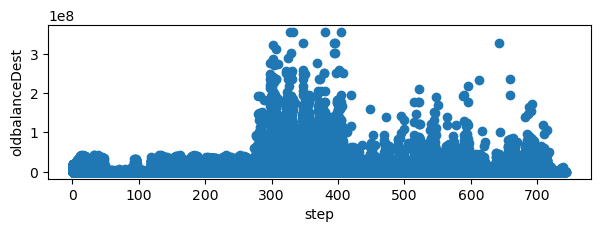

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
column 1 name : step, column 2 name : newbalanceDest


correlation_table


,covariance,r,p_val
0,1.343578e+07,0.025709,0.0




graphs


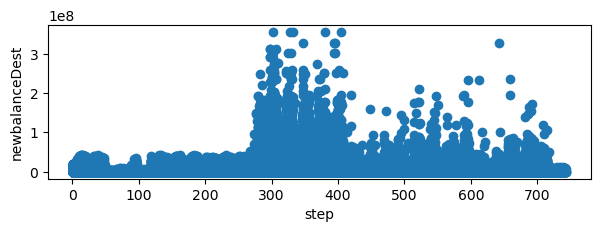

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
column 1 name : amount, column 2 name : oldbalanceOrg


correlation_table


,covariance,r,p_val
0,-4.635749e+09,-0.002648,2.286214e-08




graphs


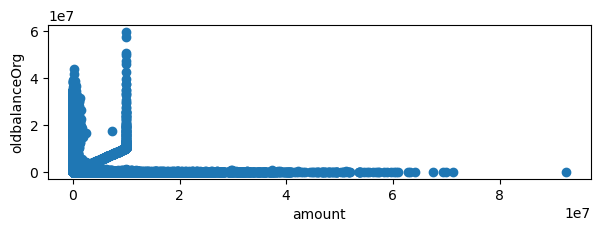

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
column 1 name : amount, column 2 name : newbalanceOrig


correlation_table


,covariance,r,p_val
0,-1.363439e+10,-0.007693,2.778917e-59




graphs


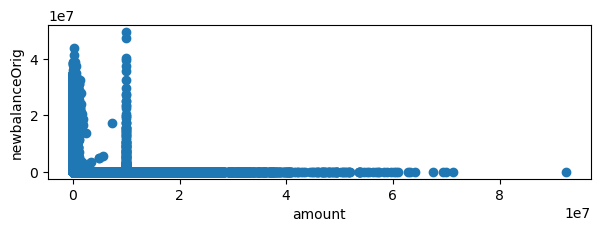

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
column 1 name : amount, column 2 name : oldbalanceDest


correlation_table


,covariance,r,p_val
0,5.982875e+11,0.290831,0.0




graphs


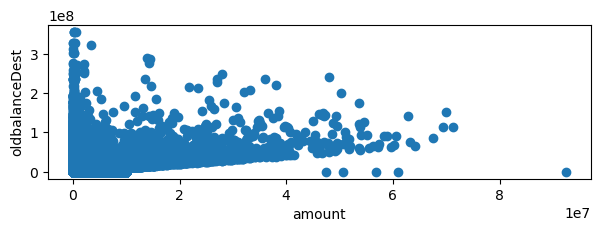

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
column 1 name : amount, column 2 name : newbalanceDest


correlation_table


,covariance,r,p_val
0,1.015448e+12,0.456653,0.0




graphs


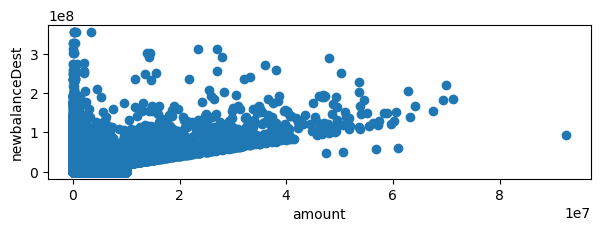

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
column 1 name : oldbalanceOrg, column 2 name : newbalanceOrig


correlation_table


,covariance,r,p_val
0,8.445891e+12,0.998808,0.0




graphs


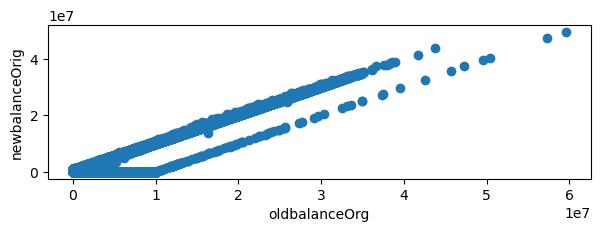

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
column 1 name : oldbalanceOrg, column 2 name : oldbalanceDest


correlation_table


,covariance,r,p_val
0,6.522698e+11,0.066452,0.0




graphs


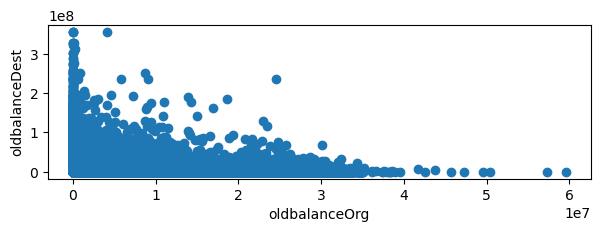

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
column 1 name : oldbalanceOrg, column 2 name : newbalanceDest


correlation_table


,covariance,r,p_val
0,4.475645e+11,0.042183,0.0




graphs


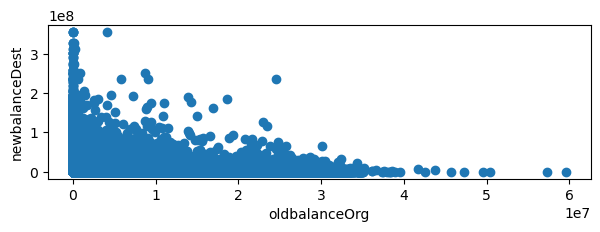

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
column 1 name : newbalanceOrig, column 2 name : oldbalanceDest


correlation_table


,covariance,r,p_val
0,6.760426e+11,0.068031,0.0




graphs


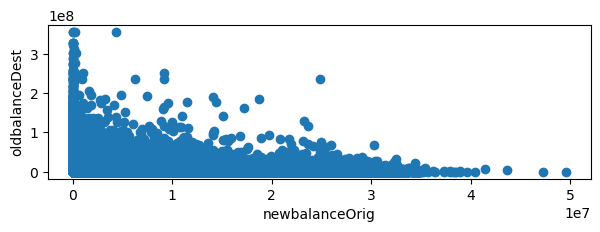

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
column 1 name : newbalanceOrig, column 2 name : newbalanceDest


correlation_table


,covariance,r,p_val
0,4.513047e+11,0.042015,0.0




graphs


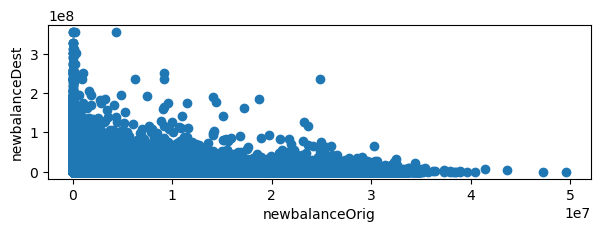

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
column 1 name : oldbalanceDest, column 2 name : newbalanceDest


correlation_table


,covariance,r,p_val
0,1.217523e+13,0.976459,0.0




graphs


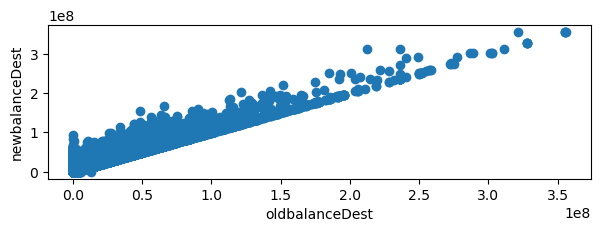

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


correlation matrix


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
step,1.000000,0.022554,-0.009919,-0.010164,0.027444,0.025709
amount,0.022554,1.000000,-0.002648,-0.007693,0.290831,0.456653
oldbalanceOrg,-0.009919,-0.002648,1.000000,0.998808,0.066452,0.042183
newbalanceOrig,-0.010164,-0.007693,0.998808,1.000000,0.068031,0.042015
oldbalanceDest,0.027444,0.290831,0.066452,0.068031,1.000000,0.976459
newbalanceDest,0.025709,0.456653,0.042183,0.042015,0.976459,1.000000


In [24]:
eda.biv_quant_all()

## One Quantitative and One Qualitative Columns

For the same reasons as above the columns nameOrig, and nameDest will be excluded.

column quantitative name : step, column qualitative name : type


anova_table


,df,sum_sq,mean_sq,F,PR(>F)
type,4.0,1.832506e+07,4.581265e+06,226.130496,1.827043e-194
Residual,4453829.0,9.023184e+10,2.025939e+04,NaN,NaN




graphs


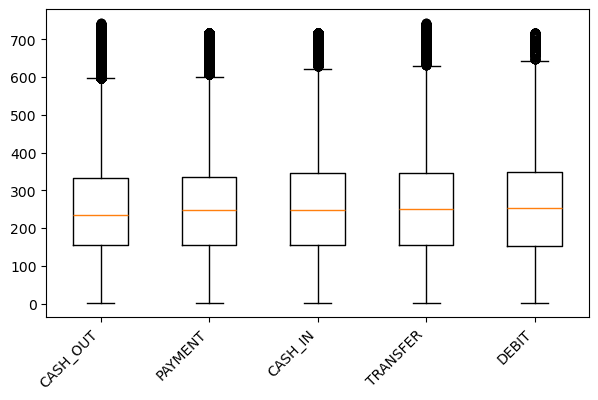

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
column quantitative name : step, column qualitative name : isFraud


anova_table


,df,sum_sq,mean_sq,F,PR(>F)
isFraud,1.0,8.739006e+07,8.739006e+07,4316.866394,0.0
Residual,4453832.0,9.016277e+10,2.024386e+04,NaN,NaN




graphs


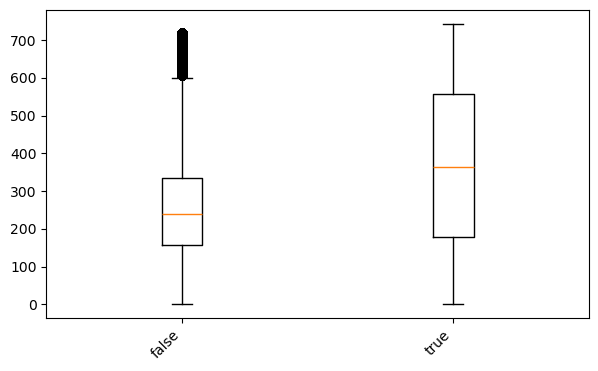

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
column quantitative name : step, column qualitative name : isFlaggedFraud


anova_table


,df,sum_sq,mean_sq,F,PR(>F)
isFlaggedFraud,1.0,1.333009e+06,1.333009e+06,65.784759,5.030826e-16
Residual,4453832.0,9.024883e+10,2.026319e+04,NaN,NaN




graphs


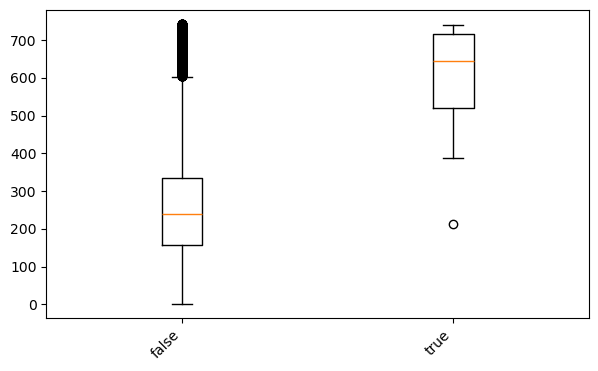

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
column quantitative name : amount, column qualitative name : type


anova_table


,df,sum_sq,mean_sq,F,PR(>F)
type,4.0,2.424572e+17,6.061430e+16,194004.776715,0.0
Residual,4453829.0,1.391542e+18,3.124371e+11,NaN,NaN




graphs


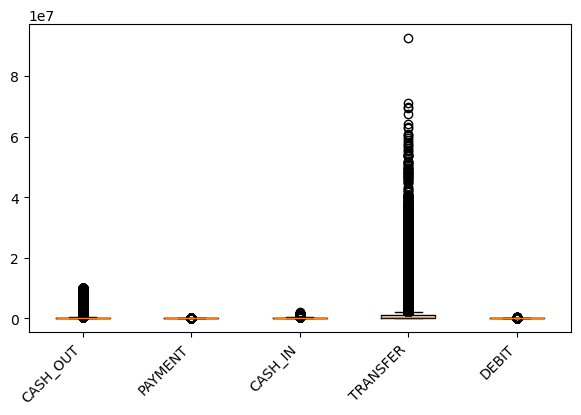

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
column quantitative name : amount, column qualitative name : isFraud


anova_table


,df,sum_sq,mean_sq,F,PR(>F)
isFraud,1.0,9.457177e+15,9.457177e+15,25927.730026,0.0
Residual,4453832.0,1.624542e+18,3.647514e+11,NaN,NaN




graphs


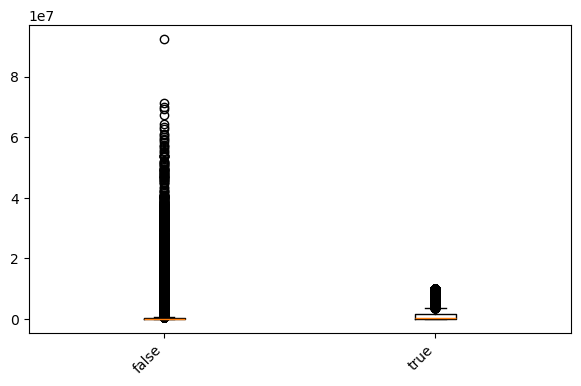

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
column quantitative name : amount, column qualitative name : isFlaggedFraud


anova_table


,df,sum_sq,mean_sq,F,PR(>F)
isFlaggedFraud,1.0,3.317900e+14,3.317900e+14,904.551989,1.052600e-198
Residual,4453832.0,1.633667e+18,3.668003e+11,NaN,NaN




graphs


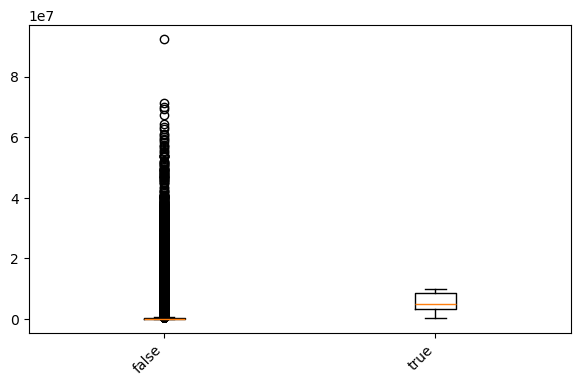

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
column quantitative name : oldbalanceOrg, column qualitative name : type


anova_table


,df,sum_sq,mean_sq,F,PR(>F)
type,4.0,9.568195e+18,2.392049e+18,385551.988505,0.0
Residual,4453829.0,2.763253e+19,6.204218e+12,NaN,NaN




graphs


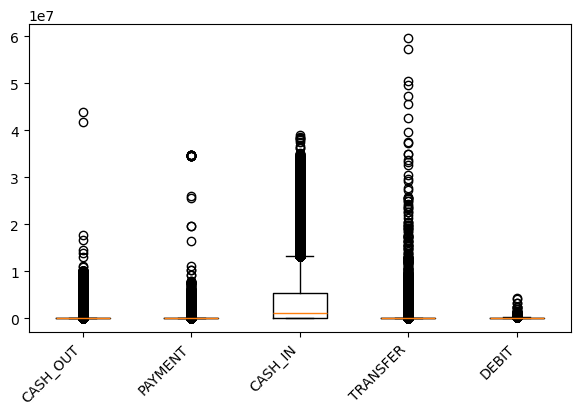

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
column quantitative name : oldbalanceOrg, column qualitative name : isFraud


anova_table


,df,sum_sq,mean_sq,F,PR(>F)
isFraud,1.0,3.908546e+15,3.908546e+15,467.997304,8.849802e-104
Residual,4453832.0,3.719681e+19,8.351643e+12,NaN,NaN




graphs


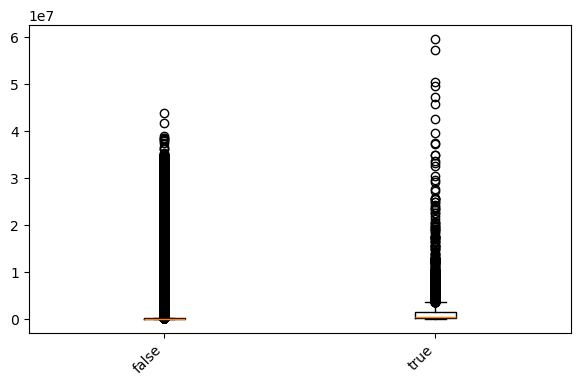

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
column quantitative name : oldbalanceOrg, column qualitative name : isFlaggedFraud


anova_table


,df,sum_sq,mean_sq,F,PR(>F)
isFlaggedFraud,1.0,7.446755e+14,7.446755e+14,89.157562,3.647531e-21
Residual,4453832.0,3.719998e+19,8.352353e+12,NaN,NaN




graphs


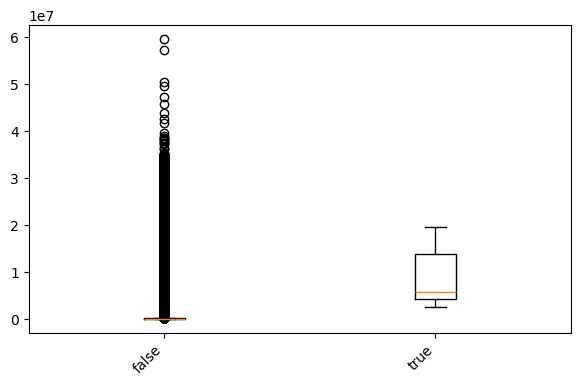

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
column quantitative name : newbalanceOrig, column qualitative name : type


anova_table


,df,sum_sq,mean_sq,F,PR(>F)
type,4.0,1.062035e+19,2.655088e+18,429892.172493,0.0
Residual,4453829.0,2.750761e+19,6.176172e+12,NaN,NaN




graphs


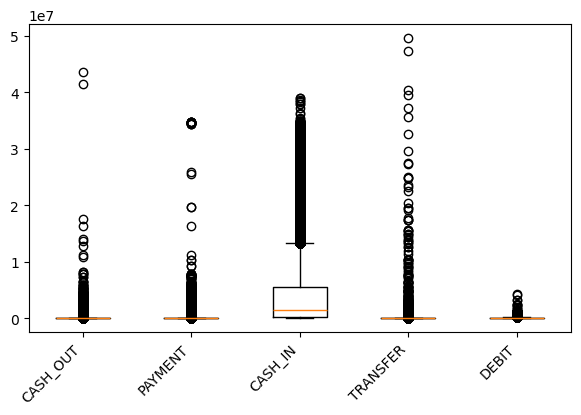

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
column quantitative name : newbalanceOrig, column qualitative name : isFraud


anova_table


,df,sum_sq,mean_sq,F,PR(>F)
isFraud,1.0,2.407896e+15,2.407896e+15,281.290668,3.947134e-63
Residual,4453832.0,3.812556e+19,8.560170e+12,NaN,NaN




graphs


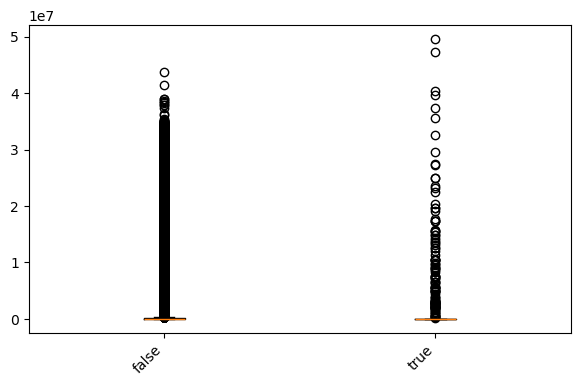

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
column quantitative name : newbalanceOrig, column qualitative name : isFlaggedFraud


anova_table


,df,sum_sq,mean_sq,F,PR(>F)
isFlaggedFraud,1.0,7.408401e+14,7.408401e+14,86.541242,1.369122e-20
Residual,4453832.0,3.812722e+19,8.560544e+12,NaN,NaN




graphs


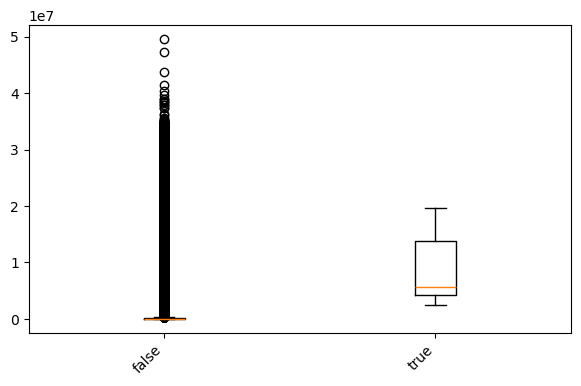

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
column quantitative name : oldbalanceDest, column qualitative name : type


anova_table


,df,sum_sq,mean_sq,F,PR(>F)
type,4.0,3.108780e+18,7.771949e+17,71715.984813,0.0
Residual,4453829.0,4.826669e+19,1.083712e+13,NaN,NaN




graphs


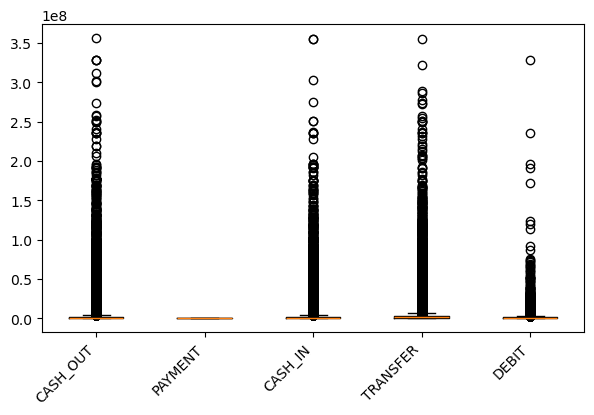

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
column quantitative name : oldbalanceDest, column qualitative name : isFraud


anova_table


,df,sum_sq,mean_sq,F,PR(>F)
isFraud,1.0,1.995535e+15,1.995535e+15,173.003229,1.636824e-39
Residual,4453832.0,5.137347e+19,1.153467e+13,NaN,NaN




graphs


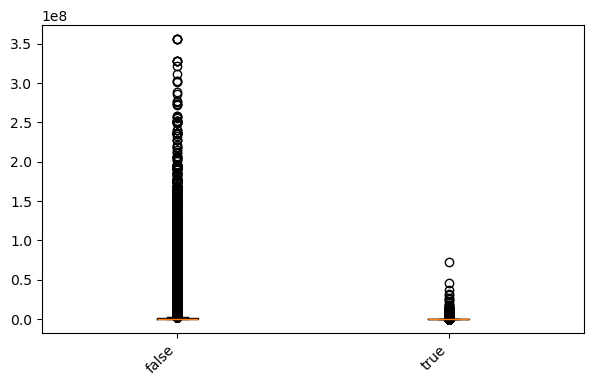

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
column quantitative name : oldbalanceDest, column qualitative name : isFlaggedFraud


anova_table


,df,sum_sq,mean_sq,F,PR(>F)
isFlaggedFraud,1.0,1.330003e+13,1.330003e+13,1.153004,0.282921
Residual,4453832.0,5.137546e+19,1.153511e+13,NaN,NaN




graphs


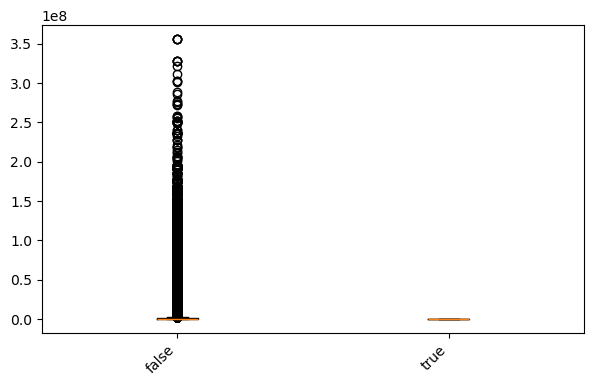

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
column quantitative name : newbalanceDest, column qualitative name : type


anova_table


,df,sum_sq,mean_sq,F,PR(>F)
type,4.0,4.681336e+18,1.170334e+18,94177.369845,0.0
Residual,4453829.0,5.534734e+19,1.242691e+13,NaN,NaN




graphs


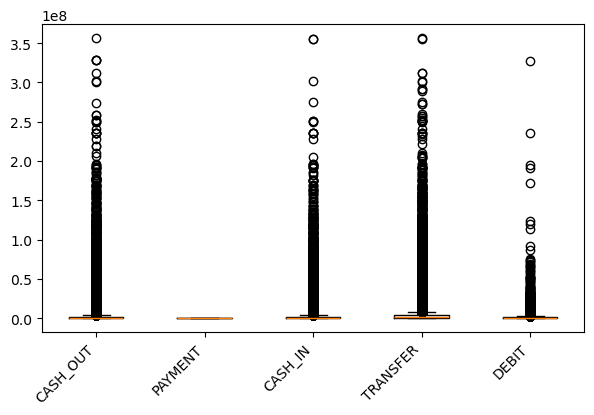

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
column quantitative name : newbalanceDest, column qualitative name : isFraud


anova_table


,df,sum_sq,mean_sq,F,PR(>F)
isFraud,1.0,1.702678e+12,1.702678e+12,0.12633,0.722268
Residual,4453832.0,6.002868e+19,1.347798e+13,NaN,NaN




graphs


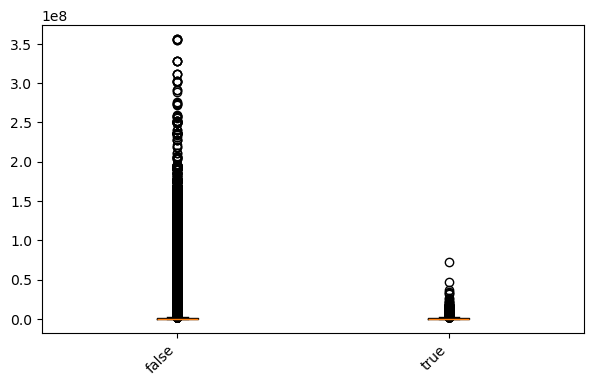

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
column quantitative name : newbalanceDest, column qualitative name : isFlaggedFraud


anova_table


,df,sum_sq,mean_sq,F,PR(>F)
isFlaggedFraud,1.0,1.647359e+13,1.647359e+13,1.22226,0.268918
Residual,4453832.0,6.002866e+19,1.347798e+13,NaN,NaN




graphs


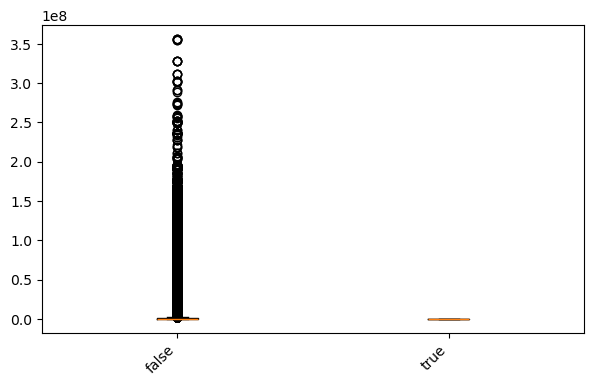

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [25]:
eda.biv_quant_qual_all(col_qual_exclude = ["nameDest", "nameOrig"])

# Potetianl Data Leakage

In [26]:
df[(df.isFraud == "false") & (df.amount == df.oldbalanceOrg)]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud


In [27]:
round(len(df[(df.isFraud == "true") & (df.amount == df.oldbalanceOrg)]) / len(df[df.isFraud == "true"]) * 100, 2)

97.74

as shown 97.74% of frauds can be predicted by checking if the amount is equal to the old balance, also when old balance is queal to amount is always fraud, keeping this in mind both of the origin balances are going to be removed from the columns used as predictors. 

on a different note the destination balances will be also removed since in mind realistically it would not be possible for an institution to
have access to that information in real conditions.

the last column to be removed will be step since its a column related to the dataset construction.